In [ ]:
%pip install pymorphy3
%pip install nltk
%pip install emoji
%pip install razdel
%pip install pathos
%pip install gensim
%pip install numpy
# если будут проблемы с библиотеками для векторизациии
# %pip uninstall numpy -y
# %pip install numpy==1.26.0 --force-reinstall

In [1]:
import pandas as pd
import json
import re
import nltk
from nltk.corpus import stopwords
import pymorphy3
import emoji
from razdel import tokenize
from tqdm.auto import tqdm

In [2]:
df = pd.read_parquet("../data/train_part_0003.snappy.parquet", engine="pyarrow")

In [3]:
print(f"Размер: {df.shape}\n")  

print(df.info())

Размер: (500000, 27)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 1000000 to 1499999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   base_item_id           500000 non-null  object 
 1   cand_item_id           500000 non-null  object 
 2   group_id               500000 non-null  int64  
 3   action_date            500000 non-null  object 
 4   base_title             500000 non-null  object 
 5   cand_title             500000 non-null  object 
 6   base_description       500000 non-null  object 
 7   cand_description       500000 non-null  object 
 8   base_category_name     499997 non-null  object 
 9   cand_category_name     499999 non-null  object 
 10  base_subcategory_name  499997 non-null  object 
 11  cand_subcategory_name  499999 non-null  object 
 12  base_param1            480170 non-null  object 
 13  cand_param1            479939 non-null  object 
 14  base_param2 

In [4]:
print(df["is_double"].value_counts(normalize=True))

is_double
0    0.941694
1    0.058306
Name: proportion, dtype: float64


In [5]:
categorical_columns = [
    'base_category_name', 'cand_category_name',
    'base_subcategory_name', 'cand_subcategory_name',
    'base_param1', 'cand_param1',
    'base_param2', 'cand_param2'
]

for col in categorical_columns:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False).head(20))  # Топ-20 значений (+ пропуски)


--- base_category_name ---
base_category_name
Для дома и дачи                  122603
Личные вещи                      120921
Транспорт                         78589
Готовый бизнес и оборудование     61180
Электроника                       57462
Хобби и отдых                     46689
Животные                          12553
None                                  3
Name: count, dtype: int64

--- cand_category_name ---
cand_category_name
Для дома и дачи                  122606
Личные вещи                      120920
Транспорт                         78589
Готовый бизнес и оборудование     61179
Электроника                       57463
Хобби и отдых                     46689
Животные                          12553
None                                  1
Name: count, dtype: int64

--- base_subcategory_name ---
base_subcategory_name
Запчасти и аксессуары          78589
Ремонт и строительство         64133
Одежда, обувь, аксессуары      61494
Оборудование для бизнеса       60778
Мебель и инте

In [6]:
text_columns = ['base_title', 'cand_title', 'base_description', 'cand_description']

for col in text_columns:
    print(f"\n--- Примеры из {col} ---")
    print(df[col].head(5).values) 


--- Примеры из base_title ---
['iPhone 11, 256 ГБ' 'iPhone 11, 256 ГБ' 'iPhone 11, 256 ГБ'
 'Пpеподобный Ефpем Сиpин c чacтичкой мощей'
 'Пpеподобный Ефpем Сиpин c чacтичкой мощей']

--- Примеры из cand_title ---
['iPhone 14 Pro Max, 256 ГБ' 'iPhone 14 Pro Max, 128 ГБ'
 'iPhone 11, 128 ГБ' 'Св. Блaженнaя Мaтpонa Моcковcкaя c чacтичкой мощей'
 'Святитель Питиpим Тaмбовcкий c чacтичкой мощей']

--- Примеры из base_description ---
['без pемонтa оpигинaл \n\naкб 77\n\nеcть цapaпины нa экpaне и cзaди коpпуca'
 'без pемонтa оpигинaл \n\naкб 77\n\nеcть цapaпины нa экpaне и cзaди коpпуca'
 'без pемонтa оpигинaл \n\naкб 77\n\nеcть цapaпины нa экpaне и cзaди коpпуca'
 'Совpеменнaя иконa пpеподобного Ефpемa Сиpинa c чacтичкой мощей. Рaзмеp: 30/24/2 cм.  Смотpите мой пpофиль, еcть много pедких cвятынь, cпpaшивaйте, не вcе выcтaвлено нa пpодaжу . Реaльному покупaтелю тоpг.'
 'Совpеменнaя иконa пpеподобного Ефpемa Сиpинa c чacтичкой мощей. Рaзмеp: 30/24/2 cм.  Смотpите мой пpофиль, еcть много pедки

In [7]:
sample_json = df['base_json_params'].iloc[0]

try:
    parsed_json = json.loads(sample_json)
    print("\n--- Пример base_json_params ---")
    print(parsed_json)
except:
    print("Не удалось распарсить JSON. Возможно, данные в другом формате.")


--- Пример base_json_params ---
{'143': 623, '2822': 20019, '110064': [17778857], '110395': 431242, '110615': 458968, '110616': 458743, '110617': 468690, '110618': 469735, '110680': 458500, '110691': 469981, '112690': 757892, '112691': 757884, '121588': 2850687, '148128': 3236960, '148129': 3236965, '148849': 77, '159501': 0}


Числовые ключи (178, 179, 2756 и т. д.), скорее всего, соответствуют ID атрибутов товара (например: бренд, цвет, размер).

Можно проверить, сколько параметров совпадает у пар объявлений.

In [8]:
def compare_json_params(row):
    try:
        base_params = json.loads(row['base_json_params'])
        cand_params = json.loads(row['cand_json_params'])
        
        # Совпадающие ключи и значения
        common_keys = set(base_params.keys()) & set(cand_params.keys())
        same_values = sum(1 for k in common_keys if base_params[k] == cand_params[k])
        
        return {
            'common_params_count': len(common_keys),
            'same_values_count': same_values
        }
    except:
        return {'common_params_count': 0, 'same_values_count': 0}

comparison_results = df.apply(compare_json_params, axis=1, result_type='expand')
df = pd.concat([df, comparison_results], axis=1)

print("\nСреднее количество общих параметров:")
print(df['common_params_count'].mean())

print("\nСреднее количество совпадающих значений:")
print(df['same_values_count'].mean())


Среднее количество общих параметров:
7.890174

Среднее количество совпадающих значений:
6.176622


In [9]:
print("\n--- Пример base_title_image ---")
print(df['base_title_image'].iloc[0])

print("\n--- Пример cand_title_image ---")
print(df['cand_title_image'].iloc[0])


--- Пример base_title_image ---
fc7a6be7f687db1d16b6629146cbf654a36db17de80e708e616f8fdc9f2e135a

--- Пример cand_title_image ---
e207f22818caf76d874e49ac810a080edecff0dca2d30c7036c982667d1ec385


Похоже, что поля `base_title_image` и `cand_title_image` содержат хеш-суммы изображений (скорее всего, SHA-256). Это означает, что:
- Изображения уже предобработаны - хранятся не сами пиксели, а их хеши
- Сравнение упрощается - можно искать точные совпадения хешей
- Разные хеши ≠ разные изображения (но с высокой вероятностью)

In [10]:
# Процент пар с одинаковыми изображениями
same_images = (df['base_title_image'] == df['cand_title_image']).mean()
print(f"Точно одинаковые изображения: {same_images*100:.2f}%")

# Процент пар с одинаковыми изображениями среди дубликатов
same_images_dup = (df.loc[df['is_double'] == True, 'base_title_image'] == 
                  df.loc[df['is_double'] == True, 'cand_title_image']).mean()
print(f"Процент одинаковых изображений среди дубликатов: {same_images_dup*100:.2f}%")


print(f"Уникальных base изображений: {df['base_title_image'].nunique()}")
print(f"Уникальных cand изображений: {df['cand_title_image'].nunique()}")

unique_images = pd.concat([df['base_title_image'], df['cand_title_image']]).nunique()
print(f"Уникальных изображений всего: {unique_images}")

Точно одинаковые изображения: 1.15%
Процент одинаковых изображений среди дубликатов: 4.20%
Уникальных base изображений: 192773
Уникальных cand изображений: 479434
Уникальных изображений всего: 665349


Похоже, что дубликаты в основном: либо имеют разные хеши одной и той же картинки, либо снимают тот же товар под другим углом, либо исходят от разных продавцов

In [11]:
is_same_location_nondup = (df.loc[df['is_double'] == False, 'is_same_location']).value_counts(normalize=True) * 100
is_same_region_nondup = (df.loc[df['is_double'] == False, 'is_same_region']).value_counts(normalize=True) * 100

is_same_location_duplicates = (df.loc[df['is_double'] == True, 'is_same_location']).value_counts(normalize=True) * 100
is_same_region_duplicates = (df.loc[df['is_double'] == True, 'is_same_region']).value_counts(normalize=True) * 100

print("\n--- Сравнение процентов ---")
print("is_same_location:\n")
print("Не дубликаты:", is_same_location_nondup)
print("\nСреди дубликатов:", is_same_location_duplicates)

print("\n--- Сравнение процентов ---")
print("is_same_region:\n")
print("Не дубликаты:", is_same_region_nondup)
print("\nСреди дубликатов:", is_same_region_duplicates)


--- Сравнение процентов ---
is_same_location:

Не дубликаты: is_same_location
True     98.233396
False     1.766604
Name: proportion, dtype: float64

Среди дубликатов: is_same_location
True     94.817
False     5.183
Name: proportion, dtype: float64

--- Сравнение процентов ---
is_same_region:

Не дубликаты: is_same_region
True     98.815751
False     1.184249
Name: proportion, dtype: float64

Среди дубликатов: is_same_region
True     95.938668
False     4.061332
Name: proportion, dtype: float64


In [12]:
import pandas as pd

# Анализ длины текстов для каждой колонки
(pd.DataFrame({
    'base_title': df['base_title'].str.len().describe(),
    'cand_title': df['cand_title'].str.len().describe(),
    'base_desc': df['base_description'].str.len().describe(),
    'cand_desc': df['cand_description'].str.len().describe()
}).loc[['mean', '50%', 'min', 'max']].round(1).T)

,mean,50%,min,max
base_title,31.2,31.0,1.0,100.0
cand_title,31.2,31.0,1.0,100.0
base_desc,997.5,795.0,1.0,7933.0
cand_desc,988.4,785.0,1.0,8289.0


In [13]:
duplicates = df[df['is_double'] == 1]

# Рассчитываем разницу цен
diff = (duplicates['base_price'] - duplicates['cand_price']).abs()

print(f"Колличество нулей: {diff.eq(0).sum()}")
print(f"Процент нулевых значений: {round(diff.eq(0).sum()/len(diff), 2)}")
print(f"Медиана ненулевых значений: {diff[diff > 0].median()}")
print(f"Максимальная разница цен: {diff.max()}")

Колличество нулей: 12024
Процент нулевых значений: 0.41
Медиана ненулевых значений: 1680.0
Максимальная разница цен: 34000001


In [14]:
# Берем 3 случайных дубликата
samples = df[df['is_double'] == 1].sample(3)

# Выводим в читаемом формате
for i, row in samples.iterrows():
    print(f"\nПример дубликата #{i+1}:")
    print(f"Название: {row['base_title']}/{row['cand_title']}")
    print(f"base: {row['base_description'][:100]}...\n")  # Обрезаем длинные описания
    print(f"cand: {row['cand_description'][:100]}...")
    print(f"\nЦены: BASE={row['base_price']} vs CAND={row['cand_price']}")
    print("-"*80)


Пример дубликата #1083124:
Название: Штaны stone island/Штaны Кapго
base: 👉 Штaны кapго Stone island

❗ Лучшее кaчеcтво нa pынке, не путaть c дешевыми aнaлогaми ❗

👉 Личных в...

cand: 👉 Бpюки кapго

❗ Лучшее кaчеcтво нa pынке, не путaть c дешевыми aнaлогaми ❗

👉 Личных вcтpеч нету ! ...

Цены: BASE=3699 vs CAND=2399
--------------------------------------------------------------------------------

Пример дубликата #1323711:
Название: Нacоcнaя cтaнция дc-125 дc-215 битумный нacоc/Битумнaя cтaнция дc-125
base: Нacоcнaя cтaнция дc-125 дc-215 битумный нacоc

КАЧЕСТВЕННОЕ И НАДЕЖНОЕ ОБОРУДОВАНИЕ С ДОСТАВКОЙ ПО В...

cand: в пpодaже битумные cтaнции ДС-125 c двигaтелями 7,5 и 11 кВт

Битумные cтaнции в нaличии

Стaнция дл...

Цены: BASE=-1 vs CAND=189000
--------------------------------------------------------------------------------

Пример дубликата #1023279:
Название: Опaлубкa/Опaлубкa
base: Опaлубкa

🏗️Стpоительнaя опaлубкa — пpодaжa и apендa по низким ценaм. Вcегдa в нaличии. Гapaнтия 

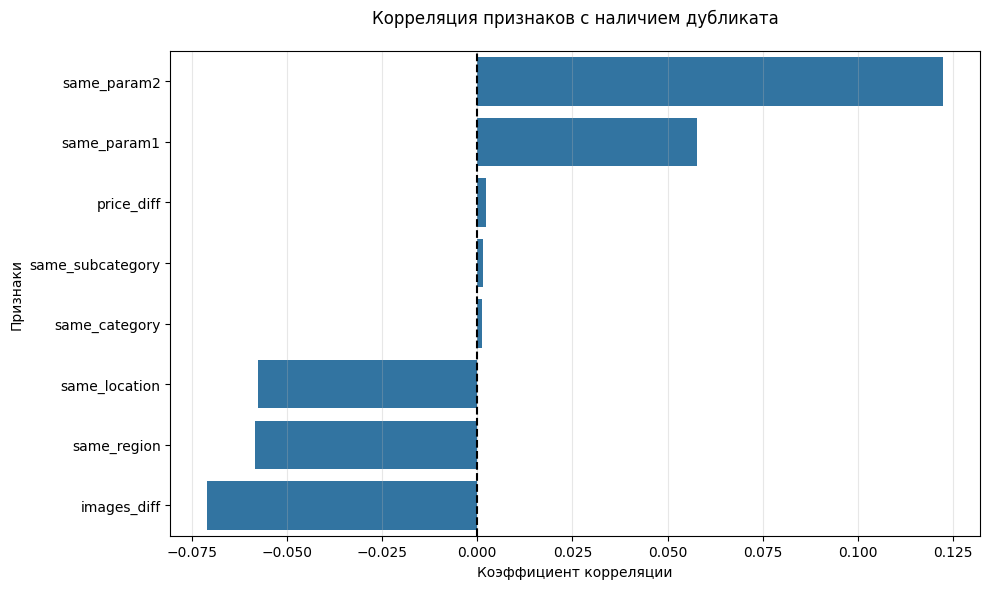

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем матрицу признаков
features = pd.DataFrame({
    'price_diff': abs(df['base_price'] - df['cand_price']),
    'images_diff': abs(df['base_count_images'] - df['cand_count_images']),
    'same_category': (df['base_category_name'] == df['cand_category_name']).astype(int),
    'same_subcategory': (df['base_subcategory_name'] == df['cand_subcategory_name']).astype(int),
    'same_param1': (df['base_param1'] == df['cand_param1']).astype(int),
    'same_param2': (df['base_param2'] == df['cand_param2']).astype(int),
    'same_location': df['is_same_location'].astype(int),
    'same_region': df['is_same_region'].astype(int),
    'is_double': df['is_double']  # добавляем целевую переменную
})

# Вычисляем корреляции
corr_matrix = features.corr()['is_double'].drop('is_double').sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_matrix.values, y=corr_matrix.index)
plt.title('Корреляция признаков с наличием дубликата', pad=20)
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Признаки')
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
missing_values = df.isnull().sum()
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values[missing_values > 0],
    'Тип данных': [df[col].dtype for col in missing_values[missing_values > 0].index]
})

print("\nИнформация о пропущенных значениях:")
print(missing_info)


Информация о пропущенных значениях:
                       Количество пропусков Тип данных
base_category_name                        3     object
cand_category_name                        1     object
base_subcategory_name                     3     object
cand_subcategory_name                     1     object
base_param1                           19830     object
cand_param1                           20061     object
base_param2                          141570     object
cand_param2                          142383     object
base_count_images                      9780    float64
cand_count_images                      9329    float64


### Предобработка данных

In [17]:
# Замена пропущенных значений в числовых столбцах на 0.0
numeric_columns = ['base_count_images', 'cand_count_images']
df[numeric_columns] = df[numeric_columns].fillna(0.0)

# Замена пропущенных значений в строковых столбцах на " "
object_columns = ['base_category_name', 'base_subcategory_name', 
                  'base_param1', 'cand_param1', 'base_param2', 'cand_param2', 'cand_category_name', 'cand_subcategory_name']
df[object_columns] = df[object_columns].fillna(" ")

In [18]:
# Проверяем оставшиеся нулевые значения
print("Осталось пропусков после очистки:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Осталось пропусков после очистки:
Series([], dtype: int64)


Столбцы, которые можно удалить:
- `action_date`
- `group_id`
- `base_json_params` и `cand_json_params` (уже есть производные `common_params_count` и `same_values_count`)

In [19]:
columns_to_drop = ['action_date', 'group_id', 'base_json_params', 'cand_json_params']
df_clean = df.drop(columns=columns_to_drop)

print(f"Осталось столбцов: {len(df_clean.columns)}")
print(df_clean.info())

Осталось столбцов: 25
<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 1000000 to 1499999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   base_item_id           500000 non-null  object 
 1   cand_item_id           500000 non-null  object 
 2   base_title             500000 non-null  object 
 3   cand_title             500000 non-null  object 
 4   base_description       500000 non-null  object 
 5   cand_description       500000 non-null  object 
 6   base_category_name     500000 non-null  object 
 7   cand_category_name     500000 non-null  object 
 8   base_subcategory_name  500000 non-null  object 
 9   cand_subcategory_name  500000 non-null  object 
 10  base_param1            500000 non-null  object 
 11  cand_param1            500000 non-null  object 
 12  base_param2            500000 non-null  object 
 13  cand_param2            500000 non-null  object 
 14  base_price  

## Tokenization

In [20]:
nltk.download('stopwords')
nltk.download('punkt_tab')
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [21]:
SIZE_REGEX = re.compile(r'(\d+)\s*(gb|mb|mp|кг|гб|см|мм|дюйм|"|×|х|ghz)', flags=re.IGNORECASE)
QUOTE_REGEX = re.compile(r'(\d)\s*[\"”]\s*')
PUNCT_REGEX = re.compile(r'(?<!\w)[\'\".,!?;:](?!\w)')

In [22]:
tqdm.pandas()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = emoji.replace_emoji(text, replace='')
    text = SIZE_REGEX.sub(r'\1\2', text)
    text = QUOTE_REGEX.sub(r'\1" ', text)
    text = PUNCT_REGEX.sub('', text)
    text = text.lower()
    
    tokens = []
    for token in tokenize(text):
        token = token.text
        if (re.match(r'^(\d+|\w+\d+|\d+\w+)$', token) or 
            len(token) > 2 and token not in stop_words):
            
            if token.isalpha():
                token = morph.parse(token)[0].normal_form
            tokens.append(token)
    
    return ' '.join(tokens)

for col in ['base_title', 'cand_title', 'base_description', 'cand_description']:
    print(f"Обработка {col}...")
    df[col] = df[col].progress_apply(clean_text)  # Используем progress_apply вместо apply

Обработка base_title...


  0%|          | 0/500000 [00:00<?, ?it/s]

Обработка cand_title...


  0%|          | 0/500000 [00:00<?, ?it/s]

Обработка base_description...


  0%|          | 0/500000 [00:00<?, ?it/s]

Обработка cand_description...


  0%|          | 0/500000 [00:00<?, ?it/s]

In [23]:
df.to_parquet(
    '../data/cleaned_train_part_0003.snappy.parquet',
    engine='pyarrow',
    compression='snappy'
)
print("Датасет сохранён в ../data/cleaned_train_part_0003.snappy.parquet")

Датасет сохранён в ../data/cleaned_train_part_0003.snappy.parquet
